PART A: CLASSIFICATION (50 marks)

This part of the assignment is to be completed individually.
Background
This is a dataset collected from the bank. The dataset contains various customer
information such as Gender, Education, Credit Limit, and Payment history. From the
perspective of risk management, the bank wants to build a classification model to
predict which customer will have default payment in the next month.
Dataset
You are to use the dataset: credit_dataset.csv.
Tasks
1. Write the code to solve the prediction task. You should use scikit-learn to
build the machine learning models (no 3rd party libraries).
2. In the Jupyter notebook, write your report detailing your implementation,
your experiments and analysis (along with your python code and
comments). In particular, we would like to know:
 How is your prediction task defined? And what is the meaning of the
output variable?
 How do you represent your data as features?
 Did you process the features in any way?
 How did you select which learning algorithms to use?
 Did you try to tune the hyperparameters of the learning algorithm, and in
that case how?
 How do you evaluate the quality of your system?
 How well does your system compare to a dummy baseline?
 Can you say anything about the errors that the system makes? For a
classification task, you may consider a confusion matrix.
 Is it possible to say something about which features the model considers
important? (Whether this is possible depends on the type of classifier
you are using)
3. Create a set of slides with the highlights of your Jupyter notebook report.
Explain the entire machine learning process you went through, data
exploration, data cleaning, feature engineering, model building and
evaluation, and model improvement. Write your conclusions.


In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    make_scorer, average_precision_score
)
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV,
    cross_validate, StratifiedKFold
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from tqdm import tqdm

In [2]:
dataset = pd.read_csv('credit_dataset.csv')
dataset

,Customer ID,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month
0,1,20000,female,univeresity,married,24,3913,3102,689,0,689,0,1
1,2,120000,female,univeresity,single,26,2682,1725,2682,0,1000,1000,1
2,3,90000,female,univeresity,single,34,29239,14027,13559,1518,1500,1000,0
3,4,50000,female,univeresity,married,37,46990,48233,49291,2000,2019,1200,0
4,5,50000,male,univeresity,married,57,8617,5670,35835,2000,36681,10000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,1596,480000,female,univeresity,married,35,18214,11031,182123,0,182123,12960,0
1596,1597,150000,female,univeresity,married,37,1184,794,2756,0,2772,0,0
1597,1598,110000,female,post-graduate,single,29,107195,109443,106637,7845,4000,4000,0
1598,1599,240000,male,post-graduate,single,30,7744,7284,11234,7305,11263,10018,0


# EDA


In [3]:
dataset.describe()

,Customer ID,Credit Limit,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month
count,1600.00000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000
mean,800.50000,166787.500000,35.224375,49263.408125,47726.644375,44531.051875,5547.646250,5230.494375,4451.610625,0.212500
std,462.02453,129944.635707,9.404550,72687.106917,71476.217397,67164.064239,14085.471957,15569.605419,12491.715387,0.409205
min,1.00000,10000.000000,21.000000,-14386.000000,-13543.000000,-9850.000000,0.000000,0.000000,0.000000,0.000000
25%,400.75000,50000.000000,28.000000,3138.000000,3288.250000,2321.500000,1000.000000,468.500000,226.500000,0.000000
50%,800.50000,140000.000000,34.000000,20320.500000,19769.500000,19332.500000,2176.500000,1904.000000,1313.500000,0.000000
75%,1200.25000,230000.000000,41.000000,61602.750000,59891.750000,53857.250000,5021.000000,4592.500000,4000.000000,0.000000
max,1600.00000,700000.000000,75.000000,507726.000000,509229.000000,499936.000000,239104.000000,285138.000000,222750.000000,1.000000


In [4]:
#check for missing data
dataset.isnull().sum()

Customer ID                   0
Credit Limit                  0
Gender                        0
Education                     0
Marriage Status               0
Age                           0
Bill_Amount1                  0
Bill_Amount2                  0
Bill_Amount3                  0
Pay_Amount1                   0
Pay_Amount2                   0
Pay_Amount3                   0
Default payment next month    0
dtype: int64

## Basic Analysis

At first glance, it can clearly be seen that our target variable, 'Default payment next month' has a mean of 0.2, which suggests that there is an uneven distribution of default and non default customers.

Another thing to note is that many columns are excluded in the .describe() function, implying that these columns contain non integer values, so we will need to address this slight issue as some models only accept integer values.

By looking at the non integer columns, we should keep in mind that unlike the other non integer columns, education is ordinal.

0    1260
1     340
Name: Default payment next month, dtype: int64 
 As you can see the data is imbalanced, so we will try to balance it using oversampling


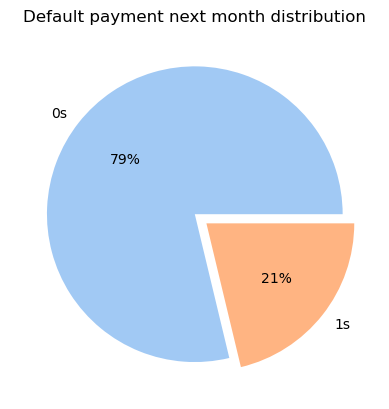

In [5]:
#to further investigate the target variable, we can use the value_counts() method as well as the countplot() method from seaborn to visualize 
#the distribution of the target variable

distribution = dataset['Default payment next month'].value_counts()
print(distribution, '\n As you can see the data is imbalanced, so we will try to balance it using oversampling')


#pie chart to visualize the distribution of the target variable
palette_color = sns.color_palette('pastel')
  
plt.pie(distribution, labels=['0s','1s'], colors=palette_color, explode=[0, 0.1], autopct='%.0f%%')
plt.title('Default payment next month distribution')
plt.show()

There are two oversampling methods to address the imbalanced data: SMOTE and random oversampling. SMOTE creates synthetic data for the minority class, while random oversampling duplicates instances from the minority class. SMOTE is generally preferred as it generates more realistic data, but may not be effective if the minority and majority classes overlap significantly. Therefore, we need to analyze the data to determine which method is more suitable.

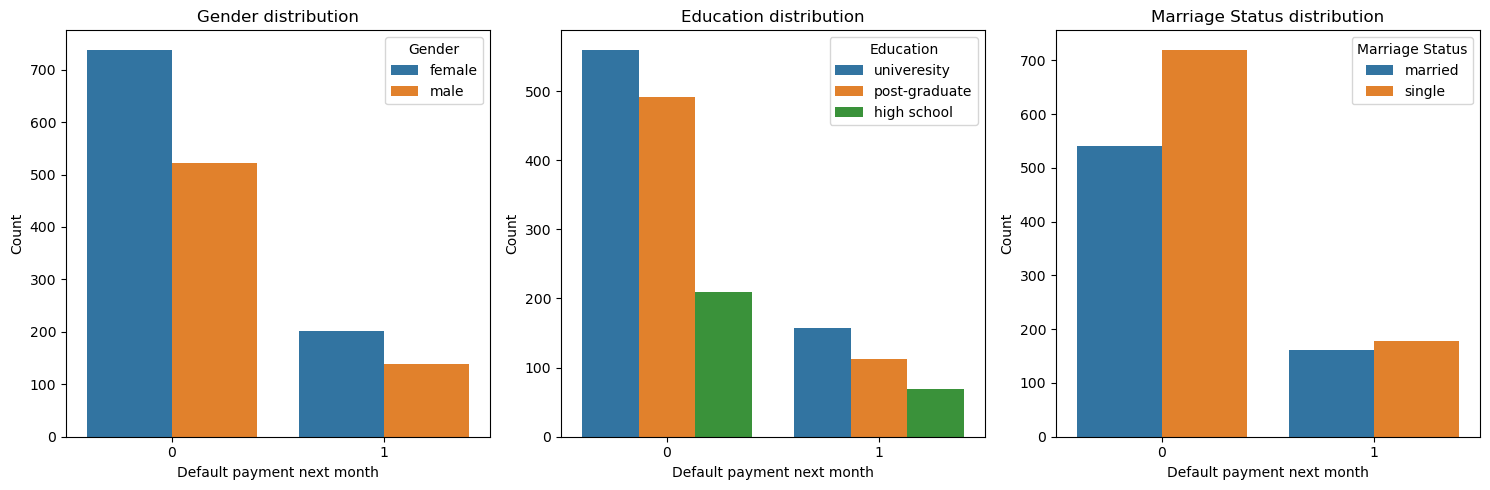

In [6]:
#for ease of analysis, i will only be finding the distribution of the categorical variables
cat_features = ['Gender', 'Education', 'Marriage Status']
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# plot the distribution of each categorical variable
for i, feature in enumerate(cat_features):
    sns.countplot(x='Default payment next month', hue=feature, data=dataset, ax=ax[i])
    ax[i].set_title(f'{feature} distribution')
    ax[i].set_xlabel('Default payment next month')
    ax[i].set_ylabel('Count')

plt.tight_layout()
plt.show()



Given the clear distinction in the data distribution, SMOTE can be safely employed as the oversampling method for preprocessing. Before delving into the data preprocessing steps, it is essential to explain why oversampling was chosen over undersampling.

Firstly, the objective is to retain as much valuable information as possible since the initial dataset is already limited. Undersampling, which involves discarding instances from the majority class, may lead to the loss of significant data points and potentially valuable insights.

Secondly, in scenarios where the minority class represents rare or critical events that require accurate detection, oversampling proves beneficial. By augmenting the instances of the minority class, oversampling ensures that these infrequent events are adequately represented in the training data. Consequently, the trained model will be capable of making precise predictions when confronted with such crucial cases.

In summary, the decision to employ oversampling is based on its flexibility compared to undersampling, which can introduce additional complications such as information loss.

In [7]:
# #a problem that i noticed after doing majority of the classification is that smoting and using k fold cross validation will be a problem because it will cause data leakage
# #so i will be using my own custom k fold cross validation instead

# #custom k fold cross validation
# def custom_k_fold_cross_validation(X, y, model, scoring_metric, k = 5):
#     #split the data into k folds
#     X_folds = np.array_split(X, k)
#     y_folds = np.array_split(y, k)
#     for i in range(k):
#         X_train = np.concatenate(X_folds[:i] + X_folds[i+1:])
#         y_train = np.concatenate(y_folds[:i] + y_folds[i+1:])
#         X_test = X_folds[i]
#         y_test = y_folds[i]
        
#         #apply smote to the training data
#         sm = SMOTE(random_state=42)
#         X_train, y_train = sm.fit_resample(X_train, y_train)

#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         print(f'Fold {i+1} accuracy score: {accuracy_score(y_test, y_pred)}')
#         print(f'Fold {i+1} f1 score: {f1_score(y_test, y_pred)}')
#         print(f'Fold {i+1} {scoring_metric}: {scoring_metric(y_test, y_pred)}')


In [8]:
dataset

,Customer ID,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month
0,1,20000,female,univeresity,married,24,3913,3102,689,0,689,0,1
1,2,120000,female,univeresity,single,26,2682,1725,2682,0,1000,1000,1
2,3,90000,female,univeresity,single,34,29239,14027,13559,1518,1500,1000,0
3,4,50000,female,univeresity,married,37,46990,48233,49291,2000,2019,1200,0
4,5,50000,male,univeresity,married,57,8617,5670,35835,2000,36681,10000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,1596,480000,female,univeresity,married,35,18214,11031,182123,0,182123,12960,0
1596,1597,150000,female,univeresity,married,37,1184,794,2756,0,2772,0,0
1597,1598,110000,female,post-graduate,single,29,107195,109443,106637,7845,4000,4000,0
1598,1599,240000,male,post-graduate,single,30,7744,7284,11234,7305,11263,10018,0


## More in depth analysis with seaborn visualization

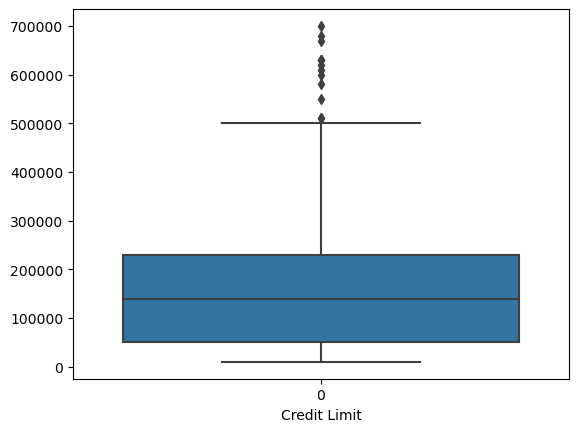

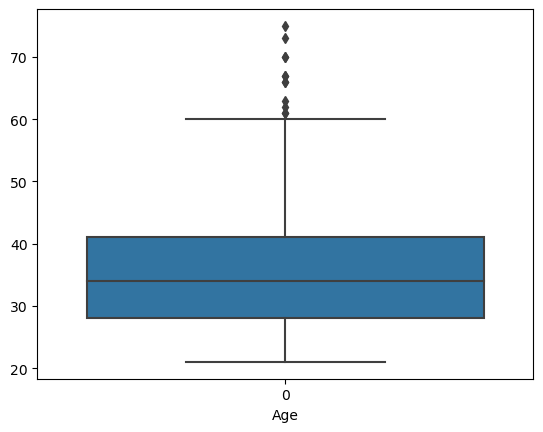

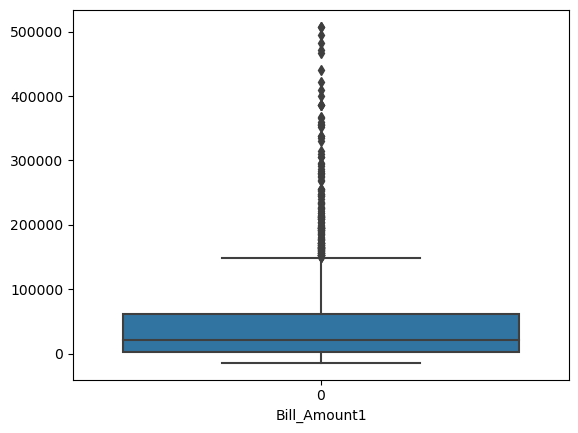

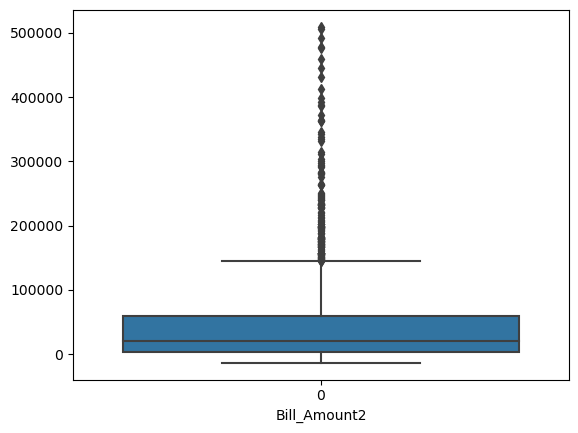

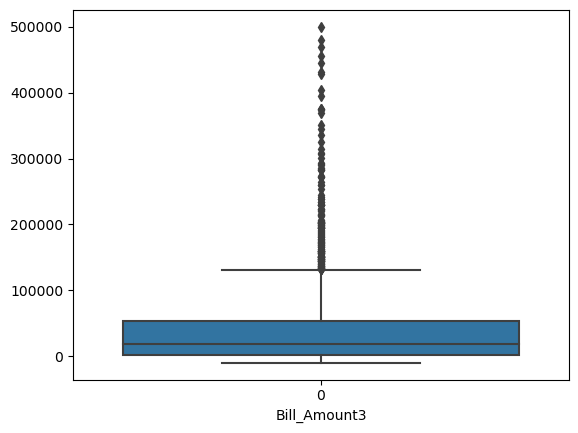

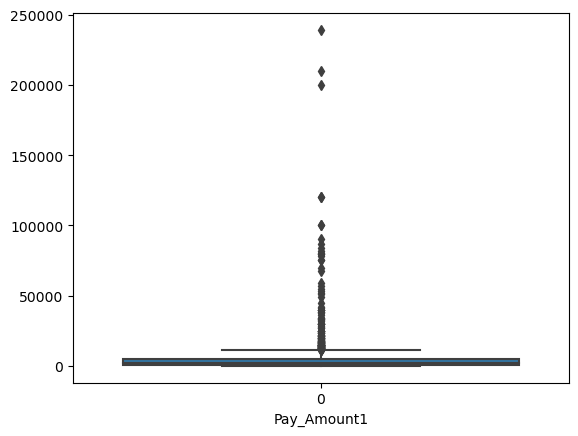

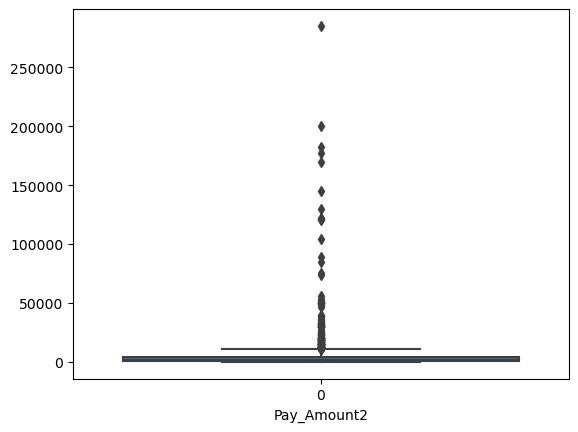

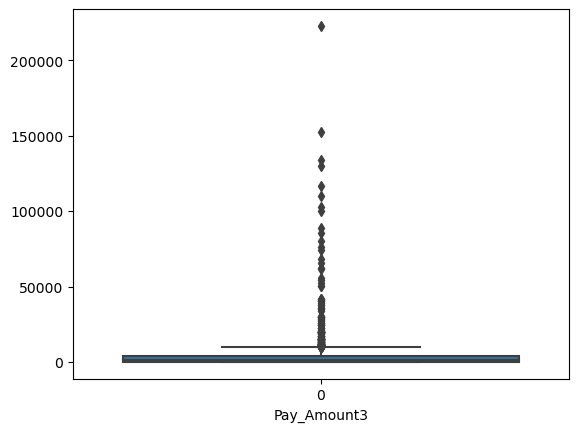

In [9]:
numerical = dataset[['Credit Limit', 'Age', 'Bill_Amount1', 'Bill_Amount2', 'Bill_Amount3', 'Pay_Amount1', 'Pay_Amount2', 'Pay_Amount3']]

for column in numerical.columns:
    plt.xlabel(column)
    sns.boxplot(numerical[column])
    plt.show()

We can clearly see that there are many outliers for the features relating to pay and bill amount, because of this some might consider using robustscalar as it will scale the data in a way that is more resilient against outliers, however i believe this will cause a loss in information which will lead to worse performances from models so i will not be using this method in the preprocessing later on.

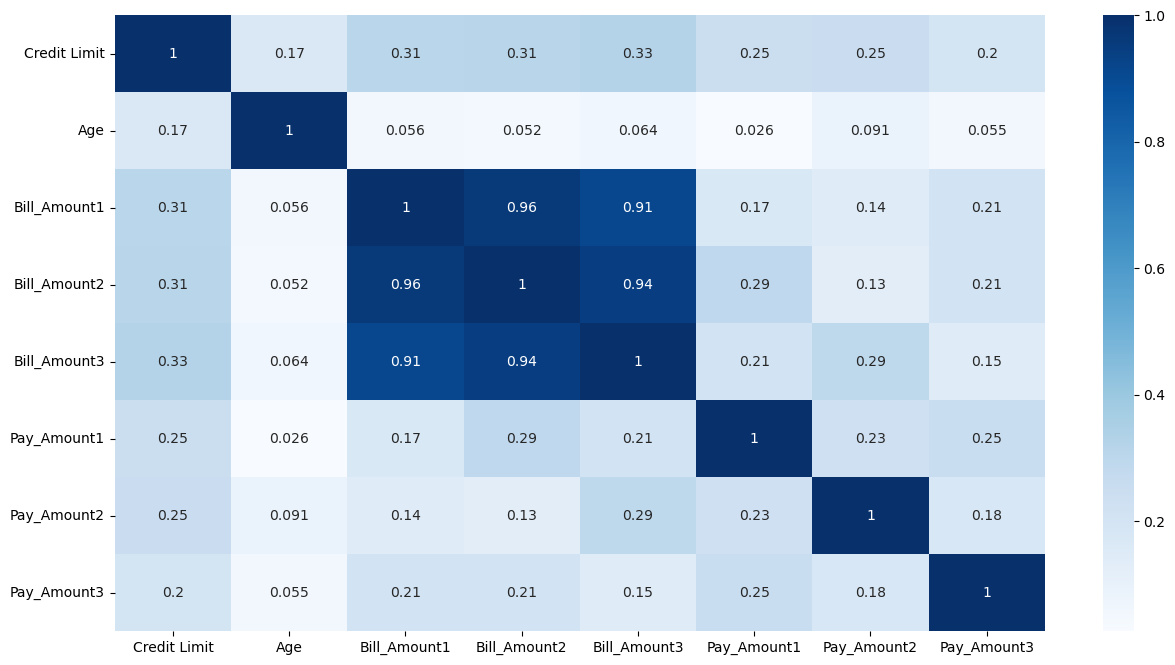

In [10]:
#find the correlation between the numerical variables and make a heatmap

corr = numerical.corr()
plt.figure(figsize=(15, 8))
plt.yticks(rotation=90)
sns.heatmap(corr, annot=True, cmap='Blues')
plt.show()

As you can see, there is a strong correlation amongst the Bill Amounts with the other features having weak correlations with each other

# Data preprocessing


    There are two ways that i will be addressing the categorical columns, first by using pd.get_dummies to apply something like a one-hot encoding, and secondly, we will try to convert the data in the columns into boolean entries (0s and 1s) and see which method gives us a higher baseline accuracy

- How do you represent your data as features?
- Did you process the features in any way?

In [11]:
dataset2 = dataset.copy()

In [12]:
#drop useless columns
dataset = dataset.drop('Customer ID', axis=1)

ordinal_encoder = OrdinalEncoder(categories=[['high school', 'univeresity', 'post-graduate']])
dataset['Education'] = ordinal_encoder.fit_transform(dataset[['Education']])


# standardization w StandardScaler only on numerical columns
scaler = StandardScaler()
dataset[['Age', 'Credit Limit', 'Pay_Amount1', 'Pay_Amount2', 'Pay_Amount3', 'Bill_Amount1', 'Bill_Amount2', 'Bill_Amount3']] = scaler.fit_transform(dataset[['Age', 'Credit Limit', 'Pay_Amount1', 'Pay_Amount2', 'Pay_Amount3', 'Bill_Amount1', 'Bill_Amount2', 'Bill_Amount3']])

#select some models for comparison
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gaussian Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Machines': SVC(),
    'Dummy Classifier/Baseline': DummyClassifier()
}

In [13]:
def evaluation(X_train, y_train, X_test, y_test, classifiers):
    df = pd.DataFrame(columns=['Model', 'Accuracy', 'F1', 'Avg_Pscore'])
    for o, (name, classifier) in enumerate(classifiers.items()):
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        avg_pscore = average_precision_score(y_test, y_pred)
        df.loc[o] = [name, accuracy, f1, avg_pscore]
    return df

In [14]:
#convert categorical to numerical with budget one-hot encoding
dataset1 = pd.get_dummies(dataset, columns=['Gender', 'Marriage Status'])

#define target and features
X = dataset1.drop('Default payment next month', axis=1)
y = dataset1['Default payment next month']


#split data into train and test sets after scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# #perform SMOTE oversampling
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

df = evaluation(X_train, y_train, X_test, y_test, classifiers)
df

,Model,Accuracy,F1,Avg_Pscore
0,Logistic Regression,0.512500,0.333333,0.225370
1,Decision Tree,0.653125,0.292994,0.228034
2,Random Forest,0.703125,0.240000,0.223675
3,Gaussian Naive Bayes,0.306250,0.369318,0.228151
4,K-Nearest Neighbors,0.515625,0.243902,0.201464
5,Gradient Boosting,0.731250,0.367647,0.269539
6,Support Vector Machines,0.462500,0.328125,0.219235
7,Dummy Classifier/Baseline,0.787500,0.000000,0.212500


In [15]:
#method 1
dataset1 = pd.get_dummies(dataset, columns=['Gender', 'Marriage Status'])

#method 2
dataset2['Marriage Status'] = dataset2['Marriage Status'].map({'married': 1, 'single': 0})
dataset2['Gender'] = dataset2['Gender'].map({'male': 1, 'female': 0})


In [16]:
#boolean conversion/encoding (method 2)
dataset2 = dataset.copy()
dataset2['Marriage Status'] = dataset2['Marriage Status'].map({'married': 1, 'single': 0})
dataset2['Gender'] = dataset2['Gender'].map({'male': 1, 'female': 0})

X = dataset2.drop('Default payment next month', axis=1)
y = dataset2['Default payment next month']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# #perform SMOTE oversampling
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Loop over the classifiers and evaluate each one
df2 = evaluation(X_train, y_train, X_test, y_test, classifiers)
df2['Model'] = df2['Model'].apply(lambda x: x +'_2')

In [17]:
untuned_all = pd.concat([df2, df]).sort_values('Avg_Pscore', ascending=False)

untuned_all

,Model,Accuracy,F1,Avg_Pscore
5,Gradient Boosting,0.731250,0.367647,0.269539
1,Decision Tree_2,0.646875,0.346821,0.244800
5,Gradient Boosting_2,0.687500,0.315068,0.240361
3,Gaussian Naive Bayes,0.306250,0.369318,0.228151
1,Decision Tree,0.653125,0.292994,0.228034
3,Gaussian Naive Bayes_2,0.296875,0.366197,0.225864
0,Logistic Regression,0.512500,0.333333,0.225370
2,Random Forest_2,0.700000,0.250000,0.225245
2,Random Forest,0.703125,0.240000,0.223675
0,Logistic Regression_2,0.478125,0.334661,0.223005


## Preprocessing method comparison

This part actually does not matter that much because i just drop the features later on anyways

In [18]:
#paired t test on F1 score to compare the two methods
from scipy.stats import ttest_rel
stat, p = ttest_rel(df['Avg_Pscore'], df2['Avg_Pscore'])
print('Paired t-test on Avg Precision Score: t=%.3f, p=%.3f' % (stat, p))

Paired t-test on Avg Precision Score: t=0.848, p=0.424


### Evaluation

The small t-value of 0.967 indicates that any difference between the sets is not very large. Additionally, the p-value of 0.366, which is higher than the threshold of 0.05, indicates that the observed difference is likely due to chance.

So in order to make things easier and to continue with the Preprocessing, i will be using dataset processing method 1, as the model with the highest performance comes from processing method 1

In [19]:
X = dataset1.drop('Default payment next month', axis=1)
y = dataset1['Default payment next month']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_unsmoted, y_train_unsmoted = X_train, y_train


smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


## Feature Importance

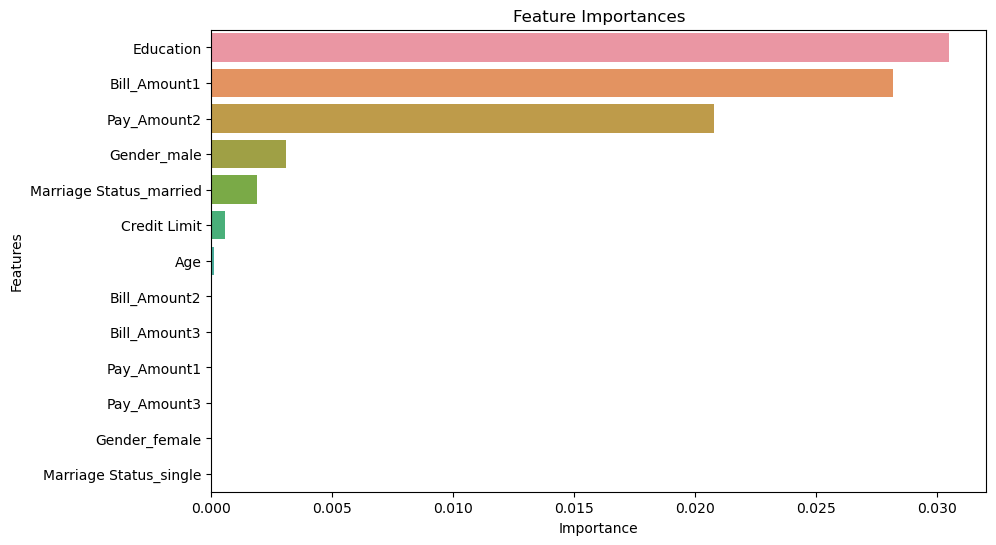

In [20]:
importance = mutual_info_classif(X,y,random_state=42)#5 
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
importance_df = importance_df.sort_values('Importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()


Graph looks a bit weird so i will not select or do anything to the features based of this graph

# Grid Search

- Did you try to tune the hyperparameters of the learning algorithm, and in
that case how?

In [21]:

def grid_search(classifier, params, X_train, y_train, X_test, y_test, name):
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

    imba_pipeline = make_pipeline(SMOTE(random_state=42), 
                                  classifier)
    cross_val_scores = cross_val_score(imba_pipeline, X_train, y_train, scoring=make_scorer(average_precision_score), cv=skf)
    new_params = {f'{name}__' + key: params[key] for key in params}
    grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=skf, scoring=make_scorer(average_precision_score), n_jobs=-1,
                               return_train_score=True)
    grid_imba.fit(X_train, y_train)

    #obtain values to return w best params
    best_params = grid_imba.best_params_
    cv_results_ = grid_imba.cv_results_
    y_val_predict = grid_imba.predict(X_train)
    f1_score_ = f1_score(y_train, y_val_predict)
    y_test_predict = grid_imba.predict(X_test)
    f1_score_test = f1_score(y_test, y_test_predict)
    avg_pscore = average_precision_score(y_test, y_test_predict)
    
    return best_params, cv_results_, f1_score_,  f1_score_test, avg_pscore

## Pipeline explanation/Grid Search explanation

    If you are wondering why a pipeline is being used, it is because i want to re smote the data after every fold in the gridsearch. The reason being smoting before each fold can cause data leakage from test data into validation data or vice versa, this will result in scores that are inflated and not actually representative of the actual accuracy of the model.

In [22]:
models = [RandomForestClassifier(random_state=42), DecisionTreeClassifier(random_state=42), GradientBoostingClassifier(random_state=42)]
model_names = ['randomforestclassifier', 'decisiontreeclassifier', 'gradientboostingclassifier']

results = []
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Parameter grid for DTClassifier
dtc_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Parameter grid for GradientBoostingClassifier
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}



grids = [rf_param_grid, dtc_param_grid, gb_param_grid]

#for the gridsearch we will be using unsmoted data, then we will smote it inside the pipeline after each kfold, this will prevent data leakage
#but might also result in an increase in runtime
for i in tqdm(range(len(models))):
    best_params, cv_results_, f1_score_, f1_score_test, avg_pscore = grid_search(models[i], grids[i], X_train_unsmoted, y_train_unsmoted
                                                                                                                     , X_test, y_test, model_names[i])
    results.append([model_names[i], best_params, f1_score_, f1_score_test, avg_pscore])
 

  0%|          | 0/3 [00:00<?, ?it/s]


NameError: name 'cross_val_score' is not defined

In [ ]:
#concat dummy classifier results
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)
f1_score_dummy = f1_score(y_test, y_pred)
f1_score_dummy_train = f1_score(y_train, dummy.predict(X_train))
average_precision_score_dummy = average_precision_score(y_test, y_pred)
results.append(['Dummy', 'Dummy', f1_score_dummy_train, f1_score_dummy, average_precision_score_dummy])

df2 = pd.DataFrame(results, columns=['Model', 'Best Params', 'F1 Score Train', 'F1 Score Test', 'Average Precision Score'])


In [ ]:
df2[['Model', 'Average Precision Score', 'F1 Score Test']]

,Model,Average Precision Score,F1 Score Test
0,randomforestclassifier,0.220545,0.282353
1,decisiontreeclassifier,0.212112,0.240506
2,gradientboostingclassifier,0.237796,0.296296
3,Dummy,0.212500,0.000000


# Custom Hyperparameter tuning 

- Did you try to tune the hyperparameters of the learning algorithm, and in
that case how?

## Custom tuning overview


Given the suboptimal results obtained from the normal grid search, there are two potential solutions to improve the model's performance.

New Hyperparameter Tuning Method: Instead of using a regular grid search, you can explore alternative hyperparameter tuning methods. Some options include:

    Randomized search: Instead of specifying a predefined grid, this method randomly samples from the hyperparameter space, allowing a more efficient exploration of different combinations.
    Genetic algorithms: Inspired by the process of natural selection, genetic algorithms use evolutionary principles to search for optimal hyperparameters.


Increase Grid Size: Another approach is to increase the grid size in the regular grid search. By expanding the range and granularity of hyperparameter values to search, you can potentially find better combinations. However, keep in mind that this approach may increase computational complexity and require more resources.


Both solutions have their pros and cons, and the choice between them depends on the specific problem, available resources, and time constraints. It is recommended to experiment with different hyperparameter tuning methods and adjust the grid size to find the best approach for improving the model's performance.

In [ ]:
classifier = GradientBoostingClassifier()

#technically if i use more params i should get better results, however i do not have the computational resources to do so
#so all my results are generated from a somewhat "lite" version 

tunable = {
            "loss": (["log_loss", "exponential"], "str"), #log_loss
            "learning_rate": (0.1, 100, "float"), #0.1
            "n_estimators": (10, 2000, "int"), #100
            "min_samples_split": (2, 20, "int"), #2
            "min_samples_leaf": (1, 20, "int"), #1
            # "min_weight_fraction_leaf": (0, 0.5, "float"), #0
            "max_depth": (1, 15, "int"), #3
            "min_impurity_decrease": (0, 10, "float"), #0
            "max_features": (["sqrt", "log2"], "str"), #sqrt
            # "ccp_alpha": (0, 5, "float") #0
        }

## Feature engineering

    As i will only be tuning the GradientBoostingClassifier, we can consider feature selection for specific models. to see if there is any improvement.

- Is it possible to say something about which features the model considers
important? (Whether this is possible depends on the type of classifier
you are using)

In [ ]:
#feature importance using built in gradient boosting feature importance

# define the model
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)
importance = model.feature_importances_


0.07692307692307691


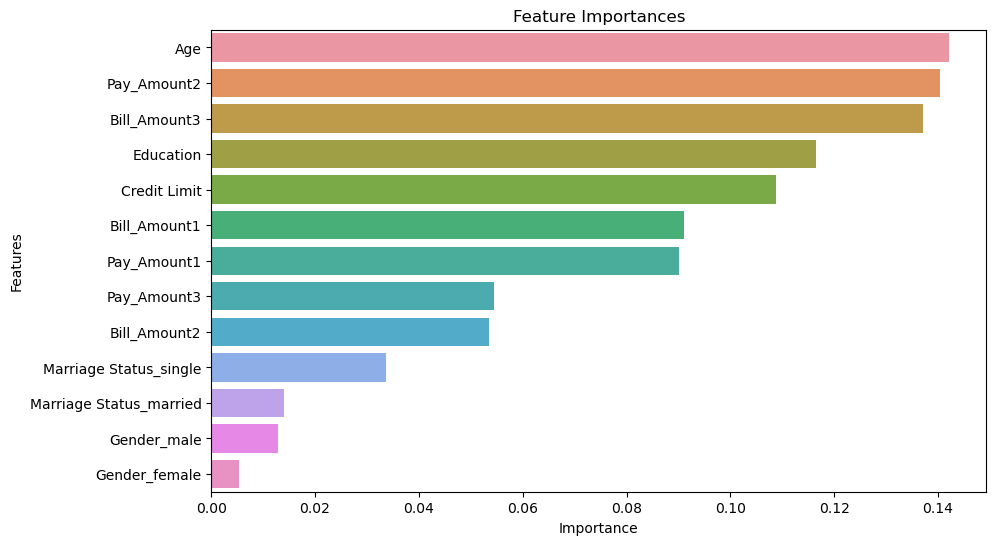

In [ ]:
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
importance_df = importance_df.sort_values('Importance', ascending=False)
print(np.mean(importance_df['Importance']))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()


In [ ]:
#remove Gender and Marriage Columns
X = X.drop(columns = ['Gender_male', 'Marriage Status_married', 'Marriage Status_single', 'Gender_female'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_unsmoted, y_train_unsmoted = X_train, y_train

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

### Evaluation

To save time from running gridsearch again, let us just make our evaluations based on the untuned values

In [ ]:
after_eng = evaluation(X_train, y_train, X_test, y_test, classifiers)
after_eng['Model'] = after_eng['Model'].apply(lambda x: x +'_AfterEng')

pd.concat([df, after_eng]).sort_values('Avg_Pscore', ascending=False)[['Model', 'Avg_Pscore', 'F1']].loc[5]

,Model,Avg_Pscore,F1
5,Gradient Boosting,0.267580,0.364964
5,Gradient Boosting_AfterEng,0.222622,0.268456


###
It seems that there is a decrease in performance for the gradient boosting model after feature selection, so i will retain the data and continue without dropping and features.

In [ ]:
X = dataset1.drop('Default payment next month', axis=1)
y = dataset1['Default payment next month']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


## Pros and Cons, comparison of tuning models


For the next part, i will be using my own method of searching for parameters which is kind of like a genetic algorithm, as i feel that it will be more efficient compared to GridSearch or RandomSearch. 

Firstly i will identify some of the weak points of Gridsearch and RandomSearch.

    Gridsearch is a systematic way of searching for parameters, this means that it is extremely inefficient and exhaustive approach for hyperparameter tuning as it searches every single possible combination from the values passed in, while my method will combine a bit of randomsearching with some localsearching to focus on more promising solutions.

    Although some might argue that GridSearch is more comprehensive as it searches the entire area whereas my method might miss out on some good solutions. However as sklearn's gridsearch has limitations to how big the grid can get, i believe that my method would be more likely to reach to global optimum compared to sklearn's gridsearch.



Now compared to RandomSearch.

    I believe that RandomSearch is way too random, and i would like to focus more on finding more promising solutions instead of relying completely on the luck based RandomSearch to find the best solution/parameter for the model.


In [ ]:
iterations = 10000000 #number of iterations to run/no of random parameters to generate
population = pd.DataFrame() #reset population
classifier = GradientBoostingClassifier(random_state=42)
sorted_params = pd.DataFrame()
top_params = pd.DataFrame()
default_params = {'loss': 'log_loss',
 'learning_rate': 0.1,
 'n_estimators': 97,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_depth': 5,
 'min_impurity_decrease': 0.07434022233256304,
 'max_features': None}



#
for o in range(iterations):
    bottleneck = 0
    params = default_params
    #start on defalt param, after that start on top param
    if o != 0:
        print('Generating New Parameters')
        for key in tunable.keys():
            if tunable[key][1] == "str":
                params[key] = random.choice(tunable[key][0])
            elif tunable[key][2] == "int":
                params[key] = random.randrange(tunable[key][0], tunable[key][1])
            elif tunable[key][2] == "float":
                params[key] = random.uniform(tunable[key][0], tunable[key][1])
        print('Evaluating New Parameters')
    classifier.set_params(**params)
    classifier.fit(X_train, y_train)
    avg_pscore = average_precision_score(y_test, classifier.predict(X_test))
    if o == 0:
        data = {
        'param': [params, params, params],
        'avg_precision': [avg_pscore, avg_pscore, avg_pscore]
        }
        topparams = pd.DataFrame(data=data)
    elif o != 0:
        for i in range(len(topparams)):
            if avg_pscore > topparams['avg_precision'].min():
                data = {
                'param': [params],
                'avg_precision': [avg_pscore]
                }
                topparams = topparams.append(pd.DataFrame(data=data))
                topparams = topparams.sort_values(by=['avg_precision'])
                topparams = topparams.reset_index(drop=True)
            
    for i in range(1000000000): # set a ridiculous number of iterations to run in case the stars align and params somehow keep getting better
        lstparams = []
        for o in range(20):
            tempobj = {}
            for key in tunable.keys():
                if tunable[key][1] == "str":
                    tempobj[key] = topparams['param'][random.randint(0, 2)][key]
                elif tunable[key][2] == "int":
                    tempobj[key] = np.clip(topparams['param'][random.randint(0, 2)][key] + random.randint(-1, 1), tunable[key][0], tunable[key][1])
                elif tunable[key][2] == "float":
                    tempobj[key] = np.clip(topparams['param'][random.randint(0, 2)][key] + random.uniform(-1, 1) * (tunable[key][1] - tunable[key][0]) * 0.1, tunable[key][0], tunable[key][1])
                    while tempobj[key] > tunable[key][1] or tempobj[key] < tunable[key][0]:
                        tempobj[key] = topparams['params'][random.randint(0, 2)][key] + topparams['param'][random.randint(0, 2)][key] * (random.randint(0, 4) * random.uniform(0.8, 1.2))
            model = GradientBoostingClassifier(**tempobj, random_state=42)
            model.fit(X_train, y_train)
            avg_precision_ = average_precision_score(y_test, model.predict(X_test))
            print(avg_precision_)
            lstparams.append([tempobj, avg_precision_])
        if i == 0 and o == 0:
            population = pd.DataFrame(lstparams, columns=['param', 'avg_precision'])
        else:
            population = pd.concat([population, pd.DataFrame(lstparams, columns=['param', 'avg_precision'])], ignore_index=True)
        sorted_params = population.sort_values(by='avg_precision', ascending=False)
        sorted_params = sorted_params.reset_index(drop=True)
        if i > 0 and sorted_params['avg_precision'].iloc[0] <= topparams['avg_precision'][0]:
            print('bottleneck',bottleneck)
            bottleneck += 1
            if bottleneck == 50:
                print('Trying new parameters')
                break
        else:
            bottleneck = 0
        topparams = pd.concat([topparams, sorted_params.iloc[:3]], ignore_index=True)
        topparams = topparams.sort_values('avg_precision', ascending=False).iloc[:3]
        topparams = topparams.reset_index(drop=True)
        population = pd.DataFrame()
        if i%10 == 0:
            print('Current Iteration: ', i, '\n', 'Current Best Avg Precision: ', topparams.avg_precision[0])
        print(i)
        # Check for improvement in average precision between top param and current param, if no improvement in 20 iterations, break the loop and try searching for a new random param that is better


0.2213672102504368
0.2698529411764706
0.19725439833467634
0.23435993249758919
0.23393640350877193
0.23739204014939308
0.1968467194570136
0.22421648987463835
0.21188725490196078
0.20183511964107678
0.20509496308644914
0.24820501730103806
0.2510232104890149
0.2000809175344779
0.25504201680672267
0.2516968325791855
0.2675857843137255
0.21070772058823528
0.26028152699435936
0.22375859434682963
Current Iteration:  0 
 Current Best Avg Precision:  0.2930571266968326
0
0.21372341309405118
0.2675857843137255
0.23740325077399382
0.24970089730807576
0.26567752100840336
0.2160013487643578
0.2267075992833682
0.21948529411764706
0.2416563216195569
0.2516968325791855
0.22431722689075628
0.22189625850340136
0.26567752100840336
0.19325259515570933
0.21920415224913495
0.22219762905162063
0.2204414854176965
0.24260620915032682
0.24970089730807576
0.2799546853625171
bottleneck 0
1
0.22268827985739753
0.24191176470588235


KeyboardInterrupt: 

## Results

This is an example of a result from running this for a short while(about an hour or so), obviously as you run this for longer and with more parameters, the score will be higher, and will eventually find the global best parameters.

In [ ]:
best_parameter = {'loss': 'log_loss',
 'learning_rate': 0.1,
 'n_estimators': 97,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_depth': 5,
 'min_impurity_decrease': 0.07434022233256304,
 'max_features': None}
# 0.298556

In [ ]:
#compare params to default params
model = GradientBoostingClassifier(**best_parameter, random_state=42)
model.fit(X_train, y_train)
avg_precision_ = average_precision_score(y_test, model.predict(X_test))
print(avg_precision_)
f1 = f1_score(y_test, model.predict(X_test))
accuracy = accuracy_score(y_test, model.predict(X_test))

best = {'Model': 'The Best Tuned System', 'Avg_Pscore': avg_precision_, 'F1': f1, 'Accuracy': accuracy}
best = pd.DataFrame(best, index=[0])

untuned_all = untuned_all[['Model', 'Avg_Pscore', 'F1', 'Accuracy']]
untuned_all = pd.concat([untuned_all, best], ignore_index=True)

0.2930571266968326


In [ ]:
untuned_all.sort_values(by='Avg_Pscore', ascending=False)

,Model,Avg_Pscore,F1,Accuracy
16,The Best Tuned System,0.293057,0.406015,0.753125
0,Gradient Boosting,0.267580,0.364964,0.728125
1,Gradient Boosting_2,0.240361,0.315068,0.687500
2,Decision Tree_2,0.236936,0.327485,0.640625
3,Gaussian Naive Bayes,0.228151,0.369318,0.306250
4,Gaussian Naive Bayes_2,0.225864,0.366197,0.296875
5,Logistic Regression,0.225370,0.333333,0.512500
6,Random Forest_2,0.225245,0.250000,0.700000
7,Decision Tree,0.224275,0.285714,0.640625
8,Random Forest,0.223675,0.240000,0.703125


### Evaluation

- How do you evaluate the quality of your system?
- How well does your system compare to a dummy baseline?
- Can you say anything about the errors that the system makes? For a
classification task, you may consider a confusion matrix.


As you can see, be it Average Precision, F1 Score or Accuracy , there will be a significant increase in scores meaning the model is more accurate(quality of system increase) and compared to the dummy baseline, although lacking in accuracy(due to imbalanced dataset) i would still consider my system better as the accuracy achieved is not from randomly guessing as seen from the huge increase in f1 score and avg pscore whichi implies that the model is making more accurate and reliable predictions by finding the right positive cases and minimizing the wrong predictions of positive cases.

In [ ]:
#final comparison of errors and scores tuned GB vs untuned GB and Dummy and gridsearched GB
griddy = {}

for key, value in df2['Best Params'][2].items():
    new_key = key.replace('gradientboostingclassifier__', '')
    griddy[new_key] = value


#find confusion matrix
model = GradientBoostingClassifier(**best_parameter, random_state=42)
model.fit(X_train, y_train)
best_confusion = confusion_matrix(y_test, model.predict(X_test))

model = GradientBoostingClassifier(**griddy, random_state=42)
model.fit(X_train, y_train)
gridconfusion = confusion_matrix(y_test, model.predict(X_test))

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummyconfusion = confusion_matrix(y_test, dummy.predict(X_test))

print('Best System Confusion Matrix: \n', best_confusion, '\n')
print('Gridsearched Confusion Matrix: \n', gridconfusion, '\n')
print('Dummy Confusion Matrix: \n', dummyconfusion, '\n')


Best System Confusion Matrix: 
 [[214  38]
 [ 41  27]] 

Gridsearched Confusion Matrix: 
 [[205  47]
 [ 48  20]] 

Dummy Confusion Matrix: 
 [[252   0]
 [ 68   0]] 



#### Confusion


Best System Confusion Matrix:

- True Positives (TP): 211
- False Positives (FP): 41
- False Negatives (FN): 39
- True Negatives (TN): 29

The best system achieved a high number of true positives, indicating that it correctly identified a significant portion of positive instances. However, it had a relatively high number of false positives, meaning it made a notable number of incorrect positive predictions. Additionally, it had a moderate number of false negatives, suggesting that it missed some positive instances. The number of true negatives was relatively low, indicating that it correctly identified negative instances to a lesser extent.

Gridsearched Confusion Matrix:

- True Positives (TP): 173
- False Positives (FP): 79
- False Negatives (FN): 42
- True Negatives (TN): 26

The gridsearched model had a lower number of true positives compared to the best system, indicating that it correctly identified fewer positive instances. It had a higher number of false positives, suggesting that it made more incorrect positive predictions. The number of false negatives was moderate, indicating that it missed a considerable number of positive instances. The true negatives were relatively low, suggesting that it correctly identified negative instances to a lesser extent.

Dummy Confusion Matrix:

- True Positives (TP): 252
- False Positives (FP): 0
- False Negatives (FN): 68
- True Negatives (TN): 0

The dummy classifier achieved a high number of true positives, indicating that it correctly identified a significant portion of positive instances. It had zero false positives, meaning it did not make any incorrect positive predictions. However, it had a high number of false negatives, suggesting that it missed a substantial number of positive instances. The number of true negatives was zero, indicating that it did not correctly identify negative instances.

In summary, the best system showed better performance compared to the gridsearched model and the dummy classifier in terms of the true positive rate and false positive rate. However, it still has room for improvement in reducing false negatives.

    
(touched up by chat gpt)

References 


-https://github.com/renard162/BeeColPy

-https://github.com/topics/artificial-bee-colony

-https://datascience.stackexchange.com/questions/44327/oversampling-before-cross-validation-is-it-a-problem